In [18]:
%pip install opencv-python clip
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install matplotlib

# CLIP

CLIP - это модель OpenAI (https://openai.com/index/clip/) Они сделали ее уже достаточно давно (2021), но актуальности она не потеряла. Это стандартная модель для картиночно-текстовых эмбедингов. В каком-то смысле это BERT для мультимодальных моделей. 
В отличие от BERT здесь используется не self-supervised learning, где обучающие данные генерируются просто из существующих данных с помощью какой-то абстрактной задачи (заполнение пропусков, предсказание следующего токена и тп), а стандартное обучение с учителем, а сам подход называется constrastive learning. В чем-то это очень похоже на word2vec c negative sampling (если помните там задача в том, чтобы два вектора которые встречаются вместе в контексте были близки, а те что не встречаются были далеки друг от друга), но здесь нужны пары картинка-текст, которые нужно размечать. Тем не менее, OpenAI собрали 400млн таких пар в интернете! Сам процесс обучение здесь достаточно понятный - есть два енкодера, текстовый и картиночный; обучающая пара текст-картинка пропускается через эти энкодеры и на выходе получается два эмбединга и в процессе обучение максимизируется близость между текстовым и картиночным эмбедингами из одной пары (и минизизируется близость между эмбедингами из других пар в батче). В результате получается две модели энкодера, который переводят текст или картинку в одно пространство. Что с этим можно делать? Например, можно искать картинки по текстовому запросу (эмбедим запросов и сравниваем с эмбедингами картинок в базе) или делать zero-shot классификаторы для картинов, где мы сравниваем картинку с каким-то списком слов (==классов) и выбираем наиболее близкий.


<!-- ![](https://images.ctfassets.net/kftzwdyauwt9/fbc4f633-9ad4-4dc2-3809c22df5e0/0bd2d5abf90d052731538613e4a42668/overview-a.svg)
![](https://images.ctfassets.net/kftzwdyauwt9/d9d46e4b-6d6a-4f9e-59a242ea1441/c7b386880f1af005fd02f159de7f4d00/overview-b.svg) -->

В то время OpenAI все еще делало действительно открытые модели. CLIP лежит в открытом доступе со свободной лицензией. Давайте его попробуем

In [4]:
from torchvision import transforms
# это вспомогательные функции чтобы картинки были поменьше
to_512 = transforms.Resize(512)
to_256 = transforms.Resize(256)

In [4]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

In [32]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [35]:
url = "https://images.ctfassets.net/440y9b545yd9/49v1AZmZdiPYkJ4A3vrayj/d7d7db21fed2ef30f5b8e3899633d292/Samoyed850.jpg"
image = Image.open(requests.get(url, stream=True).raw)

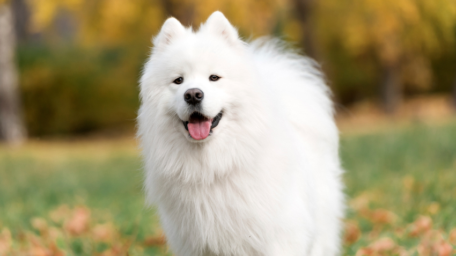

In [36]:
to_256(image)

Мы можем написать два текстовых описания и сравнить их с картинкой, чтобы на выходе получить как-бы вероятности классов (собака или кошка)

In [37]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [38]:
# вероятность собаки почти 100%
probs

tensor([[0.0017, 0.9983]], grad_fn=<SoftmaxBackward0>)

## SAM-CLIP

На картинке может быть много разных объектов и близость может размазаться между ними. Но можно воспользоваться еще одной открытой моделью - [SAM](https://github.com/facebookresearch/segment-anything) (segment almost anything, от Meta). Эта модель обучена детектировать все объекты на картинке и она возвращает маски и bounding box'ы отдельных объектов на картинке. Их можно вырезать и сравнить с текстом через clip.




In [ ]:
# скачаем модель
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import requests

In [2]:
m = build_sam(checkpoint="sam_vit_h_4b8939.pth", ).to('cuda')

In [5]:
mask_generator = SamAutomaticMaskGenerator(m)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
img_url = 'https://foldlandia.ru/wp-content/uploads/sobaka-i-koshka.png'
original_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image_array = np.array(original_image)

masks = mask_generator.generate(image_array)

In [7]:
# masks

In [8]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def segment_image(image_array: np.array, segmentation_mask):
    h, w, _ = image_array.shape
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", (w,h), (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image
# Cut out all masks

In [9]:
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image_array, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [10]:
@torch.no_grad()
def retriev(images: list[Image.Image], search_text: str) -> int:
    inputs = processor(text=search_text, images=images, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=0) # we can take the softmax to get the label probabilities
    return probs

def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [11]:
scores = retriev(cropped_boxes, "cat")
indices = get_indices_of_values_above_threshold(scores, 0.2)

In [13]:
indices

[1]

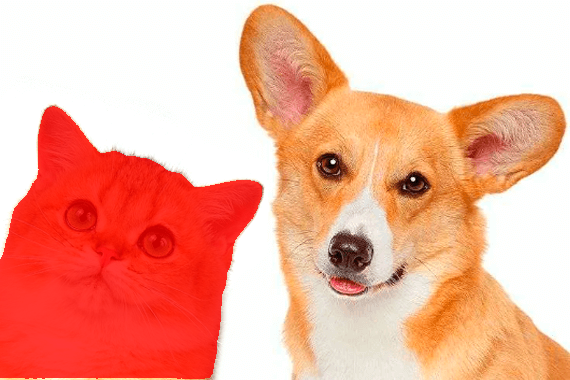

In [18]:
segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray((masks[seg_idx]["segmentation"]).astype('uint8')*255)
    segmentation_masks.append(segmentation_mask_image)


overlay_image = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
# мы определяем цвет и прозрачность чтобы подстветить этот объект
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image

## SigLIP 

CLIP от OpenAI и более поздние версии от Meta (MetaClip) остаются стандартными энкодерами для задач, где картинки встречаются с текстами и их можно встречить в статьях про мультимодальные LLM (например, Molmo). Но постепенно на смену им приходит схожая, но упрощенная модель SigLIP. В целом это точно такая же модель, которая оптимизирована сторить эмбединги текста и картинок, но они упростили лосс. В CLIP лосс рассчитывается на все батче - близости между правильными парами текст-картинка максимизируются, а между всеми остальными парами внутри батча минимизируются (предполагается что текст подходит только к одной картинке в батче, что иногда может быть неправильно, но за счет размера батча эти ошибки минимизируются). Близости превращаются в вероятности с помощью софтмакса, причем его нужно посчитать два раза (сначала по парам текст-картинка, потом по картинка-текст; то есть нормализовать по колонкам и по строкам) и это не очень эффективно. В SigLIP софтмакс заменяется на сигмоиду, которая применяется к каждой близости отдельно. Это еще сильнее похоже на word2vec c negative sampling! SigLIP обучается решать задачу бинарной классификации, предсказывая являются ли пары текст-картинка в батче правильными или нет.  

Также недавно они выпустили вторую версию SigLIP, где они добавили дополнительные задачи для оптимизации (например, локализованные описания, для создания которых они использовали что-то похожее на пример с котом выше), что позволило еще улучить результаты. 
Обе версии SigLIP есть на huggingface, а обучающий код можно найти вот тут - https://github.com/google-research/big_vision/tree/main

In [ ]:
# siglip

In [4]:
# !pip install transformers bitsandbytes accelerate sentencepiece protobuf

In [13]:
import torch
from transformers import pipeline

In [14]:
image = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
candidate_labels = ["a Pallas cat", "a lion", "a Siberian tiger"]

In [15]:
pipeline = pipeline(task="zero-shot-image-classification", model="google/siglip-base-patch16-224", device=0, torch_dtype=torch.bfloat16)
pipeline(image, candidate_labels=candidate_labels)

Device set to use cuda:0


[{'score': 0.8359375, 'label': 'a Pallas cat'},
 {'score': 0.0004444122314453125, 'label': 'a Siberian tiger'},
 {'score': 8.940696716308594e-06, 'label': 'a lion'}]

In [1]:
# siglip 2

In [2]:
from transformers import pipeline

# load pipeline
ckpt = "google/siglip2-base-patch16-224"
image_classifier = pipeline(model=ckpt, task="zero-shot-image-classification")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [3]:
# load image and candidate labels
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
candidate_labels = ["2 cats", "a plane", "a remote"]

In [6]:
# run inference
outputs = image_classifier(image=url, candidate_labels=candidate_labels)
print(outputs)

[{'score': 0.1718961000442505, 'label': '2 cats'}, {'score': 0.02414989471435547, 'label': 'a remote'}, {'score': 2.191487737945863e-06, 'label': 'a plane'}]
